In [2]:
import sys 
sys.path.append('/home/lumargot/trachoma/src/py')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [3]:
# import sys; sys.path.insert(0, '..')
# import
from tqdm import tqdm
import math
import os
import pandas as pd
import numpy as np 

import torch
from torch import Tensor, nn
from torchvision import models
from torchvision import ops

from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import nrrd
import pytorch_lightning as pl
from torchvision import transforms
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from monai.data.utils import pad_list_data_collate

import lightning as L
from lightning.pytorch.core import LightningModule
import monai
from torchvision.transforms import functional as F


from matplotlib.patches import Rectangle

from nets.segmentation import FasterRCNN
from loaders.tt_dataset import TTDatasetBX,TTDataModuleBX

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


In [81]:
mount_point = "/CMF/data/lumargot/trachoma/B images one eye/"

df_test = pd.read_csv('/CMF/data/lumargot/trachoma/patches/csv/new/Pret_excluded_clean_fold0_test.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/patches/csv/new/Pret_excluded_clean_fold0_train_test.csv')    
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/patches/csv/new/Pret_excluded_clean_fold0_train_train.csv')


df_test = df_test.loc[~df_test['label'].isin(['Healthy', 'Reject'])].reset_index()
df_val = df_val.loc[~df_val['label'].isin(['Healthy', 'Reject'])].reset_index()
df_train = df_train.loc[~df_train['label'].isin(['Healthy', 'Reject'])].reset_index()


In [83]:
df_train['class'].value_counts()

2    3421
4    1769
3     499
1     484
5     417
Name: class, dtype: int64

In [7]:
ttdata = TTDataModuleBX(df_train, df_val, df_test, batch_size=2, num_workers=2, img_column='filename', mount_point=mount_point)

In [14]:
ttdata.setup()
dataload = ttdata.train_dataloader()
ds = ttdata.test_ds

img, box, classes = ds[0]

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


In [15]:
img = ds[0]['img']
boxes = ds[0]['boxes']

In [ ]:

## ------------- display of patches + prediction -------------##
img_per = ds[0]['img'].permute(1,2,0)
ncols=5
nrows = int(ds[0]['boxes'].shape[0]/ncols) +2 # 1 for rounding, 1 for cropped_img
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout=None, figsize=(20,10))
for i in range(ds[0]['boxes'].shape[0]):
  plt.subplot(nrows,ncols,i+1)
  x1,y1,x2,y2 = ds[0]['boxes'][i]
  img_cropped = img_per[int(y1):int(y2), int(x1):int(x2)]
  # plt.title(classes[i])
  
  plt.imshow(img_cropped)

## ------------- show crop image with cubes -------------##
gs = axs[-1, -1].get_gridspec()
for ax in axs[-1,:]:
    ax.remove()
axbig = fig.add_subplot(gs[-1,:2])
axbig.imshow(img_per)

# for box_coords in box:
#   rect = Rectangle(xy=(x-patch_sz, y-patch_sz), width=2*patch_sz, height=2*patch_sz,
#                   fill=False, linewidth=2, color='red')
#   axbig.add_patch(rect)

# axbig = fig.add_subplot(gs[-1,2:4])
# axbig.imshow(img_cropped.permute(1,2,0))

# plt.title(ds.data.df.iloc[idx]['img'])


plt.show()

# Prediction

In [37]:
ckpt = '/CMF/data/lumargot/trachoma/output/object_detection/fold0/epoch=2-val_loss=0.65.ckpt'
model = FasterRCNN.load_from_checkpoint(ckpt)

The loaded checkpoint was produced with Lightning v2.3.1, which is newer than your current Lightning version: v1.9.0


In [38]:
model.eval()

for idx, batch in enumerate(tqdm(dataload)):
  
  imgs, targets = batch
  
  # targets = batch
  # imgs = targets.pop('img', None)
  break

  0%|          | 0/436 [00:00<?, ?it/s]The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Te

In [39]:
outs = model(imgs, mode='test')

### Classes

0. Healthy (dropped)

1. ECA
2. Entropion
3. Gap
4. overcorrection
5. Short Incision

6. Rejection class (dropped)

In [52]:
map = {1:'ECA',
2:'Entropion',
3:'Gap',
4:'overcorrection',
5:'Short Incision',
}

## Inputs

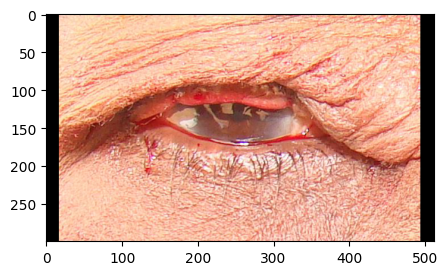

In [58]:
IDX=1
plt.figure(figsize=(5,5))
img = imgs[IDX].permute(1,2,0)
plt.imshow(img)
# plt.imshow(img[200:400, 200:400])

## Ground Truth 

In [ ]:
plt.figure(figsize=(20,10))

num_cols = 6
target = targets[IDX]
num_rows = int(len(target['labels'])/num_cols) +1

for j in range(len(target['labels'])):
  box = target['boxes'][j]
  label = target['labels'][j]

  plt.subplot(num_rows,num_cols,j+1)
  x1, y1, x2, y2 = box.cpu().detach().numpy()
  img_cropped = img[int(y1):int(y2), int(x1):int(x2), :]
  plt.imshow(img_cropped)
  plt.axis('off')
  plt.title(map[label.item()])

## Prediction

In [ ]:
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(imgs[i].permute(1,2,0))

  ax = plt.gca()
  out_img = outs[i]
  for j in range(len(out_img['labels'])):
    
    box = out_img['boxes'][j]
    label = out_img['labels'][j].cpu().detach().numpy()
    score = out_img['scores'][j].cpu().detach().numpy()

    x1, y1, x2, y2 = box.cpu().detach().numpy()
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
    # plt.title(f"class {label} ")
    # print(label, score)

In [ ]:
out_img = outs[IDX]
num_cols = 6
num_rows = int(len(out_img['labels'])/num_cols) +1
plt.figure(figsize=(2*num_rows,4*num_cols))

for j in range(len(out_img['labels'])):
  box = out_img['boxes'][j]
  label = out_img['labels'][j]
  score =out_img['scores'][j].cpu().detach().numpy()
  plt.subplot(num_rows,num_cols,j+1)
  x1, y1, x2, y2 = box.cpu().detach().numpy()
  img_cropped = img[int(y1):int(y2), int(x1):int(x2), :]

  plt.imshow(img_cropped)
  plt.axis('off')
  plt.title(f"{map[label.item()]} \nwith score {score:.2f}")

# Prediction on Besrat

In [ ]:
img_path = '/CMF/data/lumargot/trachoma/PoPP Data/img/besrat photos/1380_blsx_od_postop.jpg'
img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)

img = img.permute((2, 0, 1))
img = img/255.0
resized_image = F.resize(img, size=512)
cropped = resized_image[:,315:615,:]

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(resized_image.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(cropped.permute(1, 2, 0))

In [79]:
outs = model(cropped.unsqueeze(0), mode='test')

In [ ]:
IDX=0
img_p = cropped.permute(1,2,0)

plt.figure(figsize=(2*num_rows,4*num_cols))
out_img = outs[IDX]
num_cols = 6
num_rows = int(len(out_img['labels'])/num_cols) +1

for j in range(len(out_img['labels'])):
  box = out_img['boxes'][j]
  label = out_img['labels'][j]
  score =out_img['scores'][j].cpu().detach().numpy()
  plt.subplot(num_rows,num_cols,j+1)
  x1, y1, x2, y2 = box.cpu().detach().numpy()
  img_cropped = img_p[int(y1):int(y2), int(x1):int(x2), :]

  plt.imshow(img_cropped)
  plt.title(f"{map[label.item()]} \nwith score {score:.2f}")

  
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(img_p)

ax = plt.gca()
for j in range(len(out_img['labels'])):
  
  box = out_img['boxes'][j]

  x1, y1, x2, y2 = box.cpu().detach().numpy()
  width, height = x2 - x1, y2 - y1
  rect = Rectangle((x1, y1), width, height, fill=False, color='red')
  ax.add_patch(rect)
plt.show()


# Evaluation 

in Faster R-CNN, they used Mean AP (%) and IoU. + plot of recall csv IoU overlap ratio with ground truth boxes
Also what about the threshold, which one to select 